# **Homework 6 - Generative Adversarial Network**

This is the example code of homework 6 of the machine learning course by Prof. Hung-yi Lee.


In this homework, you are required to build a generative adversarial  network for anime face generation.


## Set up the environment


In [ ]:
# !nvidia-smi

Tue May  4 02:03:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


### Packages Installation

In [ ]:
# You may replace the workspace directory if you want.
workspace_dir = '.'

# Training progress bar
!pip install -q qqdm

### Download the dataset
**Please use the link according to the last digit of your student ID first!**

If all download links fail, please follow [here](https://drive.google.com/drive/folders/13T0Pa_WGgQxNkqZk781qhc5T9-zfh19e).

* To open the file using your browser, use the link below (replace the id first!):
https://drive.google.com/file/d/REPLACE_WITH_ID
* e.g. https://drive.google.com/file/d/1IGrTr308mGAaCKotpkkm8wTKlWs9Jq-p

In [ ]:
!gdown --id 1flLNiGE4Fe7xcifeQBwRMsc8VUAc-tIw --output "{workspace_dir}/crypko_data.zip"

# Other download links
#   Please uncomment the line according to the last digit of your student ID first

# 0
# !gdown --id 131zPaVoi-U--XThvzgRfaxrumc3YSBd3 --output "{workspace_dir}/crypko_data.zip"

# 1
# !gdown --id 1kCuIj1Pf3T2O94H9bUBxjPBKb---WOmH --output "{workspace_dir}/crypko_data.zip"

# 2
# !gdown --id 1boEoiiqBJwoHVvjmI0xgoutE9G0Rv8CD --output "{workspace_dir}/crypko_data.zip"

# 3
# !gdown --id 1Ic0mktAQQvnNAnswrPHsg-u2OWGBXTWF --output "{workspace_dir}/crypko_data.zip"

# 4
# !gdown --id 1PFcc25r9tLE7OyQ-CDadtysNdWizk6Yg --output "{workspace_dir}/crypko_data.zip"

# 5
# !gdown --id 1wgkrYkTrhwDSMdWa5NwpXeE4-7JaUuX2 --output "{workspace_dir}/crypko_data.zip"

# 6
# !gdown --id 19gwNYWi9gN9xVL86jC3v8qqNtrXyq5Bf --output "{workspace_dir}/crypko_data.zip"

# 7 
# !gdown --id 1-KPZB6frRSRLRAtQfafKCVA7em0_NrJG --output "{workspace_dir}/crypko_data.zip"

# 8
# !gdown --id 1rNBfmn0YBzXuG5ub7CXbsGwduZqEs8hx --output "{workspace_dir}/crypko_data.zip"

# 9
# !gdown --id 113NEISX-2j6rBd1yyBx0c3_9nPIzSNz- --output "{workspace_dir}/crypko_data.zip"


Downloading...
From: https://drive.google.com/uc?id=1flLNiGE4Fe7xcifeQBwRMsc8VUAc-tIw
To: /content/crypko_data.zip
452MB [00:01, 242MB/s]


###Unzip the downloaded file.
The unzipped tree structure is like 
```
faces/
├── 1.jpg
├── 2.jpg
├── 3.jpg
...
```

In [ ]:
!unzip -q "{workspace_dir}/crypko_data.zip" -d "{workspace_dir}/"

## Random seed
Set the random seed to a certain value for reproducibility.

In [ ]:
import random

import torch
import numpy as np


def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(2021)

## Import Packages
First, we need to import packages that will be used later.

Like hw3, we highly rely on **torchvision**, a library of PyTorch.

In [ ]:
import os
import glob

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from qqdm.notebook import qqdm
from torch.nn.utils import spectral_norm

## Training

### Training loop
We store some pictures regularly to monitor the current performance of the Generator, and regularly record checkpoints.

In [ ]:
!pip install stylegan2_pytorch

     |████████████████████████████████| 163kB 19.1MB/s 
     |████████████████████████████████| 276kB 31.3MB/s 
     |████████████████████████████████| 92kB 12.0MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
     |████████████████████████████████| 296kB 20.7MB/s 
     |████████████████████████████████| 153kB 31.5MB/s 
     |████████████████████████████████| 71kB 10.7MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 163kB 52.1MB/s 
     |████████████████████████████████| 61kB 9.7MB/s 
     |████████████████████████████████| 71kB 11.4MB/s 
  Created wheel for vector-quantize-pytorch: filename=vector_quantize_pytorch-0.1.0-cp37-none-any.whl size=2576 sha256=a75ac017a9ba8936ebeb00bc0d36647461b0750af2d6597174ad4f357776cfa6
  Stored in directory: /root/.cache/pip/wheels/10/68/a9/2eb0d1f485a2babf71ac5e471c9d45703cf2a2cc8686f780d2
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115928 sha256=83fe129851827813

In [ ]:
# !ln -s /content/drive/MyDrive/ML2021-hw6/models/ ./models

In [ ]:
!stylegan2_pytorch --data ./faces --network-capacity 16 --attn-layers 1 --image-size 64 --num-train-steps 150000 

continuing from previous epoch - 196
loading from version 1.8.1
default<./faces>:  98% 196000/200000 [00:00<?, ?it/s]G: 1.47 | D: 1.38 | GP: 0.08 | PL: 1.16
default<./faces>:  98% 196047/200000 [00:54<1:16:13,  1.16s/it]G: 0.37 | D: 0.96 | GP: 0.08 | PL: 1.16
default<./faces>:  98% 196096/200000 [01:47<1:10:58,  1.09s/it]G: -0.10 | D: 1.12 | GP: 0.58 | PL: 1.16
default<./faces>:  98% 196144/200000 [02:40<1:10:25,  1.10s/it]G: 0.00 | D: 1.43 | GP: 0.15 | PL: 1.15
default<./faces>:  98% 196193/200000 [03:36<1:11:39,  1.13s/it]G: 0.87 | D: 1.38 | GP: 0.11 | PL: 1.15
default<./faces>:  98% 196243/200000 [04:30<1:08:34,  1.10s/it]G: 0.65 | D: 1.50 | GP: 0.45 | PL: 1.15
default<./faces>:  98% 196291/200000 [05:24<1:08:49,  1.11s/it]G: 0.56 | D: 1.15 | GP: 0.02 | PL: 1.15
default<./faces>:  98% 196341/200000 [06:19<1:07:45,  1.11s/it]G: 0.84 | D: 1.39 | GP: 0.12 | PL: 1.15
default<./faces>:  98% 196399/200000 [07:23<1:06:00,  1.10s/it]G: 0.56 | D: 1.41 | GP: 0.46 | PL: 1.15
default<./faces>: 

In [ ]:
# !cp -r ./models /content/drive/MyDrive/ML2021-hw6/

In [ ]:
# !cp -r ./models1/default/model_0.pt /content/drive/MyDrive/ML2021-hw6/

In [ ]:
# !ln -s /content/drive/MyDrive/ML2021-hw6/models/ ./models

## Inference
Use the trained model to generate anime faces!

### Load model 

In [ ]:
log_dir = os.path.join(workspace_dir, 'logs')
os.makedirs(log_dir, exist_ok=True)

In [ ]:
from stylegan2_pytorch import ModelLoader

loader = ModelLoader(
    base_dir = './',   # path to where you invoked the command line tool
    name = 'default'                   # the project name, defaults to 'default'
    # ,load_from = 56
)

continuing from previous epoch - 200
loading from version 1.8.1


### Generate and show some images.


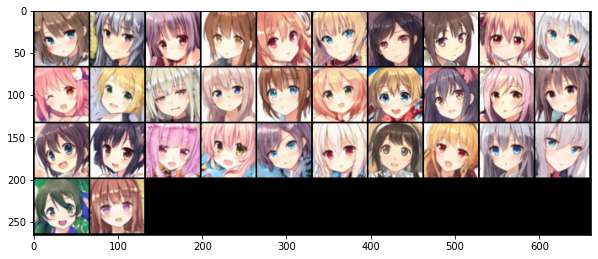

In [ ]:
noise   = torch.randn(500, 512).cuda() # noise
styles  = loader.noise_to_styles(noise, trunc_psi = 0.7)  # pass through mapping network 
imgs_sample  = loader.styles_to_images(styles) # call the generator on intermediate style vectors
torchvision.utils.save_image(imgs_sample, './logs/result.jpg', nrow=10)

# Show 32 of the images.
grid_img = torchvision.utils.make_grid(imgs_sample[:32].cpu(), nrow=10)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

# Save the generated images.
os.makedirs('output', exist_ok=True)
for i in range(500):
    torchvision.utils.save_image(imgs_sample[i], f'output/{i+1}.jpg')

In [ ]:
noise   = torch.randn(500, 512).cuda() # noise
styles  = loader.noise_to_styles(noise, trunc_psi = 0.7)  # pass through mapping network
imgs_sample  = loader.styles_to_images(styles) # call the generator on intermediate style vectors
torchvision.utils.save_image(imgs_sample, './logs/result.jpg', nrow=10)

# Show 32 of the images.
grid_img = torchvision.utils.make_grid(imgs_sample[:32].cpu(), nrow=10)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

# Save the generated images.
os.makedirs('output', exist_ok=True)
for i in range(500):
    torchvision.utils.save_image(imgs_sample[i], f'output/{i+1+500}.jpg')

### Compress the generated images using **tar**.


In [ ]:
# Compress the images.
%cd output
!tar -zcf ../images.tgz *.jpg
%cd ..

/content/output
/content


# Reference

1. lucidrains/stylegan2-pytorch:

    https://github.com/lucidrains/stylegan2-pytorch